# Using PGMPY in the Analysis of Impact of 401(k) on Net Financial Wealth


In [4]:
import networkx as nx
import warnings
warnings.simplefilter('ignore')
import pylab as plt
from pgmpy.models import DiscreteBayesianNetwork

# Graphs for 401(K) Analsyis


Here we have
 * $Y$ -- net financial assets;
 * $X$ -- worker characteristics (income, family size, other retirement plans; see lecture notes for details);
 * $F$ -- latent (unobserved) firm characteristics
 * $D$ -- 401(K) eligibility, deterimined by $F$ and $X$

**One graph (where F determines X):**


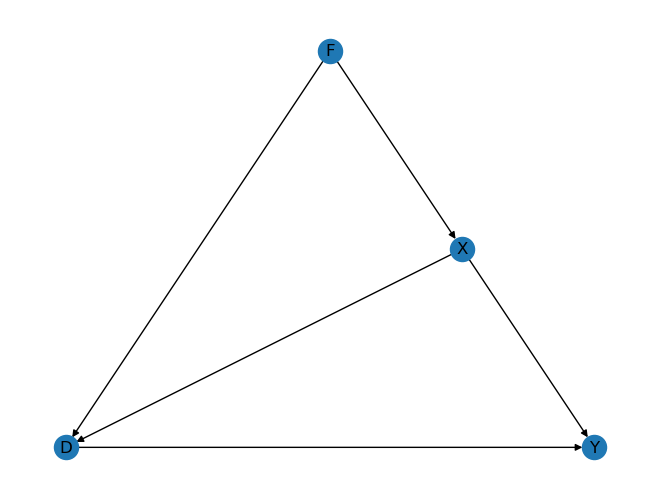

In [5]:
G = DiscreteBayesianNetwork(ebunch=[('D', 'Y'),
                            ('X', 'D'),
                            ('F', 'X'),
                            ('F', 'D'),
                            ('X', 'Y')],
                    latents=['F'])
nx.draw_planar(G, with_labels=True)
plt.show()

**List minimal adjustment sets to identify causal effects $D \to Y$**

In [15]:
from pgmpy.inference.CausalInference import CausalInference

inference = CausalInference(G)

In [16]:
try:
    print(inference.get_all_backdoor_adjustment_sets('D', 'Y'))
except ValueError as e:
    print(e.args[0])

frozenset({frozenset({'X'})})


In [17]:
inference.is_valid_backdoor_adjustment_set('D', 'Y', "X")

True

**What is the underlying principle?**

Here conditioning on X blocks backdoor paths from Y to D (Pearl).  Dagitty correctly finds X (and does many more correct decisions, when we consider more elaborate structures. Why do we want to consider more elaborate structures? The very empirical problem requires us to do so!)

**Another Graph (where $X$ determines $F$):**

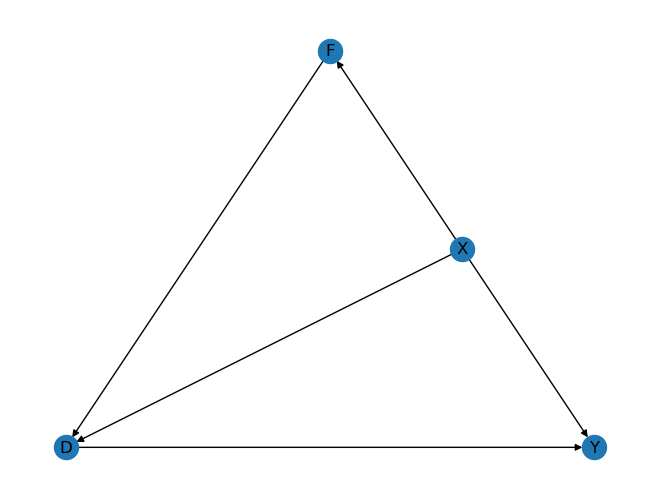

In [18]:
G2 = DiscreteBayesianNetwork(ebunch=[('D', 'Y'),
                             ('X', 'D'),
                             ('X', 'F'),
                             ('F', 'D'),
                             ('X', 'Y')],
                     latents=['F'])
nx.draw_planar(G2, with_labels=True)
plt.show()

In [13]:
inference2 = CausalInference(G2)

In [19]:
try:
    print(inference2.get_all_backdoor_adjustment_sets('D', 'Y'))
except ValueError as e:
    print(e.args[0])

frozenset({frozenset({'X'})})


**One more graph (encompassing the previous ones), where (F, X) are jointly determined by latent factors $A$.**

We can allow in fact the whole triple (D, F, X) to be jointly determined by latent factors $A$.

This is much more realistic graph to consider.

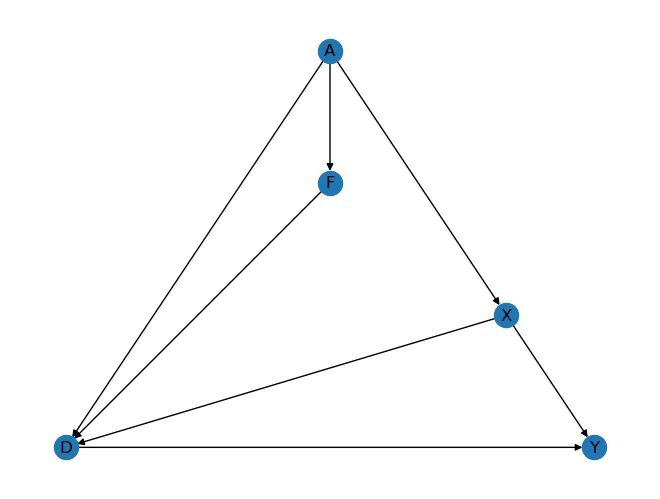

In [22]:
G3 = DiscreteBayesianNetwork(ebunch=[('D', 'Y'),
                             ('X', 'D'),
                             ('F', 'D'),
                             ('A', 'F'),
                             ('A', 'X'),
                             ('A', 'D'),
                             ('X', 'Y')],
                     latents=['F'])

nx.draw_planar(G3, with_labels=True)
plt.show()

In [24]:
inference3 = CausalInference(G3)
try:
    print(inference3.get_all_backdoor_adjustment_sets('D', 'Y'))
except ValueError as e:
    print(e.args[0])

frozenset({frozenset({'X'})})


# Threat to Identification:

What if $F$ also directly affects $Y$? (Note that there are no valid adjustment sets in this case.)

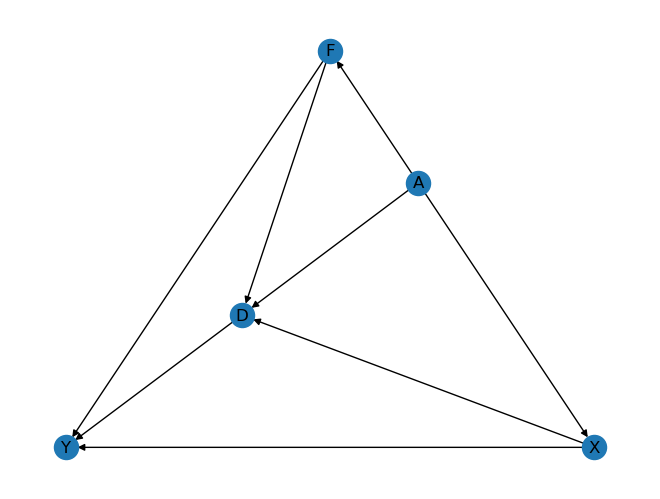

In [26]:
G4 = DiscreteBayesianNetwork(ebunch=[('D', 'Y'),
                             ('X', 'D'),
                             ('F', 'D'),
                             ('A', 'F'),
                             ('A', 'X'),
                             ('A', 'D'),
                             ('F', 'Y'),
                             ('X', 'Y')],
                     latents=['F', 'A'])

nx.draw_planar(G4, with_labels=True)
plt.show()

In [27]:
inference4 = CausalInference(G4)
try:
    print(inference4.get_all_backdoor_adjustment_sets('D', 'Y'))
except ValueError as e:
    print(e.args[0])

No valid adjustment set found for D -> Y


Note that the error here! There is no valid adustment set (among observed variables)

**How can F affect Y directly? Is it reasonable?**

Introduce Match Amount $M$. The match amount is a potential important mediator (why mediator?). $M$ is not observed. Luckily, adjusting for $X$ still works if there is no arrow $F \to M$.

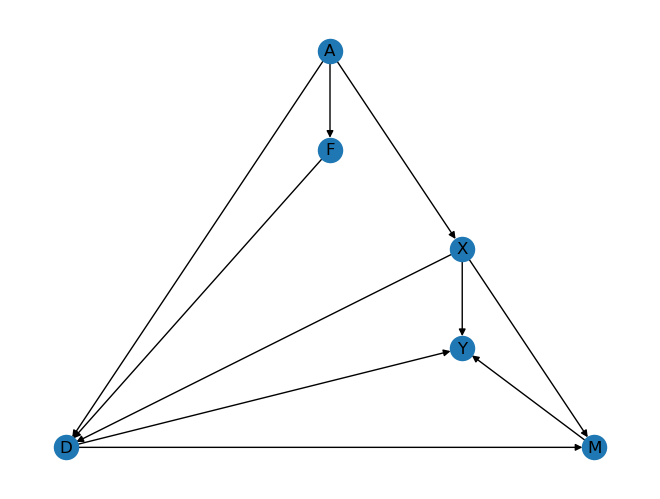

In [28]:
G5 = DiscreteBayesianNetwork(ebunch=[('D', 'Y'),
                             ('X', 'D'),
                             ('F', 'D'),
                             ('A', 'F'),
                             ('A', 'X'),
                             ('A', 'D'),
                             ('D', 'M'),
                             ('M', 'Y'),
                             ('X', 'M'),
                             ('X', 'Y')],
                     latents=['F', 'A', 'M'])

nx.draw_planar(G5, with_labels=True)
plt.show()

In [29]:
inference5 = CausalInference(G5)
try:
    print(inference5.get_all_backdoor_adjustment_sets('D', 'Y'))
except ValueError as e:
    print(e.args[0])

frozenset({frozenset({'X'})})


If there is $F \to M$ arrow, then adjusting for $X$ is not sufficient.

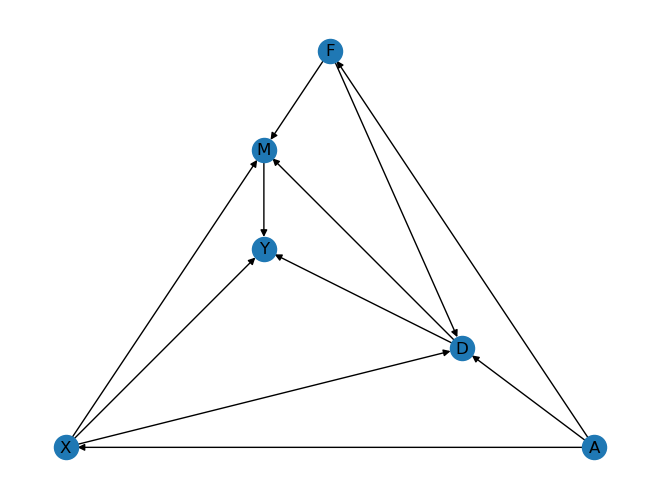

In [30]:
G6 = DiscreteBayesianNetwork(ebunch=[('D', 'Y'),
                             ('X', 'D'),
                             ('F', 'D'),
                             ('A', 'F'),
                             ('A', 'X'),
                             ('A', 'D'),
                             ('D', 'M'),
                             ('F', 'M'),
                             ('M', 'Y'),
                             ('X', 'M'),
                             ('X', 'Y')],
                     latents=['F', 'A', 'M'])

nx.draw_planar(G6, with_labels=True)
plt.show()

In [31]:
inference6 = CausalInference(G6)
try:
    print(inference6.get_all_backdoor_adjustment_sets('D', 'Y'))
except ValueError as e:
    print(e.args[0])

No valid adjustment set found for D -> Y


Again, note the error here. There is no valid adjustment set.

 # Question:

Given the analysis above, do you find the adjustment for workers' characteristics a credible strategy to identify the causal (total effect) of 401 (k) elligibility on net financial wealth?
